Multi-Layer Perceptrons (MLPs)
======

In [2]:
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

Parameter Settings
-------------------


In [3]:
num_epochs = 20
batch_size = 128
learning_rate = 1e-3
use_gpu = False

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We normalize and center them around 0, which gives a slight performance boost during training.
We create both a training set and a test set.

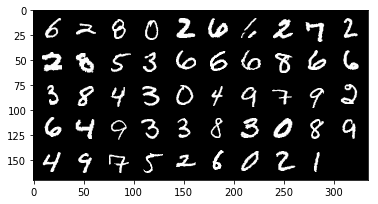

In [14]:
import numpy as np

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
plt.ion()

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# show a few MNIST digits in the training set
images, _ = iter(test_dataloader).next()
plt.imshow(np.transpose(torchvision.utils.make_grid((images[1:50]+1)*0.5,10,5).numpy(), (1, 2, 0)))
plt.show()


MLP Definition
-----------------------


In [4]:
class MultilayerPerceptron(nn.Module):
    def __init__(self):
        super(MultilayerPerceptron, self).__init__()
        
        self.conv1 = nn.Conv2d()
        
        self.fc1 = nn.Linear(in_features=28*28, out_features=512) # MNIST resolution is 28 x 28
        self.fc2 = nn.Linear(in_features=512, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=10) # 10 outputs: probability for each digit class
            
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten MNIST image to a vector

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Softmax transforms the 10 scores for each class to probabilities that sum up to 1.
        # The cross-entropy between these class probabilities and the ground truth class probabilities
        # will be used as a loss when comparing to the ground truth.
        # Cross-entropy computes a logarithm over the class probabilities, and it is numerically more stable
        # to combine the softmax computation with the logarithm, which is done below:
        x = F.log_softmax(self.fc3(x), dim=1)

        return x

mlp = MultilayerPerceptron()
if use_gpu:
    mlp = mlp.cuda()

num_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 669706


Train MLP
--------

In [5]:
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=learning_rate)

# set to training mode
mlp.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, label_batch in train_dataloader:
        
        image_batch = Variable(image_batch)
        label_batch = Variable(label_batch)
        if use_gpu:
            image_batch = image_batch.cuda()
            label_batch = label_batch.cuda()
        
        # class predictions
        prediction_batch = mlp(image_batch)
        
        # The cross-entropy loss.
        # The first input are the predicted log class probabilities.
        # The ground truth probabilites for each image are expected to be
        # 1 for a single class and 0 for all other classes.
        # This function expects as second input the index of the class with probability 1.
        # (this function is not called cross-entropy, since this function assumes
        # that the inputs are log probabilities, not probabilities).
        loss = F.nll_loss(prediction_batch, label_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.data[0]
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 20] average reconstruction error: 0.319186
Epoch [2 / 20] average reconstruction error: 0.135708
Epoch [3 / 20] average reconstruction error: 0.100948
Epoch [4 / 20] average reconstruction error: 0.079256
Epoch [5 / 20] average reconstruction error: 0.069259
Epoch [6 / 20] average reconstruction error: 0.054934
Epoch [7 / 20] average reconstruction error: 0.052416
Epoch [8 / 20] average reconstruction error: 0.045728
Epoch [9 / 20] average reconstruction error: 0.039146
Epoch [10 / 20] average reconstruction error: 0.034199
Epoch [11 / 20] average reconstruction error: 0.032968
Epoch [12 / 20] average reconstruction error: 0.026997
Epoch [13 / 20] average reconstruction error: 0.029103
Epoch [14 / 20] average reconstruction error: 0.022064
Epoch [15 / 20] average reconstruction error: 0.025578
Epoch [16 / 20] average reconstruction error: 0.024577
Epoch [17 / 20] average reconstruction error: 0.026174
Epoch [18 / 20] average reconstruction error: 0.017527
Epoch 

Plot Training Curve
--------------------

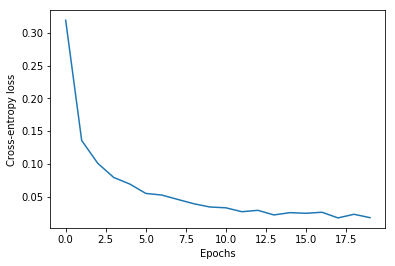

In [6]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy loss')
plt.show()

Alternatively: Load Pre-Trained Model
-----------------------------

In [7]:
mlp.load_state_dict(torch.load('./pretrained/multilayer_perceptron.pth'))

# this is how the model parameters can be saved:
# torch.save(mlp.state_dict(), './pretrained/my_multilayer_perceptron.pth')

Evaluate on the Test Set
-------------------------

The best current methods achieve a classification error percentage of around 0.21%. See [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354) for a leaderboard. Also notice that there is some overfitting: the average loss is significantly higher than for the training set. Overfitting can be reduced by adding dropout between the fully connected layers.

In [8]:
# set to evaluation mode
mlp.eval()

num_incorrect = 0
test_loss_avg = 0
num_batches = 0
num_instances = 0
for image_batch, label_batch in test_dataloader:
    
    image_batch = Variable(image_batch)
    label_batch = Variable(label_batch)
    if use_gpu:
        image_batch = image_batch.cuda()
        label_batch = label_batch.cuda()
    
    # class predictions
    prediction_batch = mlp(image_batch)
    
    # get number of correct and incorrect class predictions
    _, predicted_label = prediction_batch.max(dim=1)
    num_incorrect += (predicted_label != label_batch).sum().data[0]

    # cross-entropy loss
    loss = F.nll_loss(prediction_batch, label_batch)

    test_loss_avg += loss.data[0]
    num_batches += 1
    num_instances += image_batch.size(0)
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))
print('classification error: %f%%' % ((num_incorrect / num_instances)*100))

average loss: 0.075974
classification error: 1.820000%
